In [1]:
## Load relevant libraries

import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import weibull_min, linregress, ttest_rel
from scipy.integrate import quad
from scipy.signal import savgol_filter
from scipy.special import gamma


## Define helper functions

# Returns a linear fit (best-fit line) to the frequency data 
def get_linear_correction(data_after_size_select, x_end, fit_zone_scale_factor = 2):
    L = x_end * fit_zone_scale_factor
    x = data_after_size_select['position'][0:L]
    y = data_after_size_select['frequency'][0:L]
    slope, intercept, _, _, _ = linregress(x, y)
    y_line = slope * x + intercept
    return y_line

def get_mape(y_pred, y_true):
    if len(y_true) != len(y_pred):
        print("y_true and y_pred must have the same length")
        new_length = min(len(y_true), len(y_pred))
        y_pred = y_pred[0:new_length]
        y_true = y_true[0:new_length]
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100 * 2

def _integrand_C2(d1, x, t_min, t_max, dist1, dist2):
    """
    This is the function we integrate to find C2(x).
    """

    # Probability density of the first fragment
    f_d1 = dist1.pdf(d1)

    d2_lower_bound = np.maximum(0, x - d1)
    F_d2_lower = dist2.cdf(d2_lower_bound)
    P_small_drop = np.maximum(0, dist2.cdf(t_min) - F_d2_lower)
    P_large_drop = 1.0 - dist2.cdf(np.maximum(d2_lower_bound, t_max))

    P_drop = P_small_drop + P_large_drop

    return f_d1 * P_drop

def calculate_C2(x, t_min, t_max, shape, scale):
    """
    Calculates the second-order correction term C2(x) by numerical integration.
    """

    dist1 = weibull_min(c=shape, scale=scale)  # first fragment
    dist2 = weibull_min(c=shape, scale=scale*2)  # second fragment
    
    a = 0
    b = x
            
    result, _ = quad(_integrand_C2, a, b, args=(x, t_min, t_max, dist1, dist2))
    return result



def correction_second_order(x, threshold_min, threshold_max, shape, scale):
    """
    Calculates the probability that a specific position x is dropped because
    it falls within the first fragment and that fragment is too short, plus a correction term based on thesecond fragment 
    the input scale and shape parameters are the weibull parameters of the simulation's internal fragmentation distribution
    """
    dist1 = weibull_min(c=shape, scale=scale/2)  
    prob_L1_less_than_x = dist1.cdf(x) 
    prob_L1_less_than_t = dist1.cdf(threshold_min) 
    C_1 = prob_L1_less_than_t- prob_L1_less_than_x 
    C_2 = calculate_C2(x, threshold_min, threshold_max, shape, scale/2)
    return C_1 + C_2


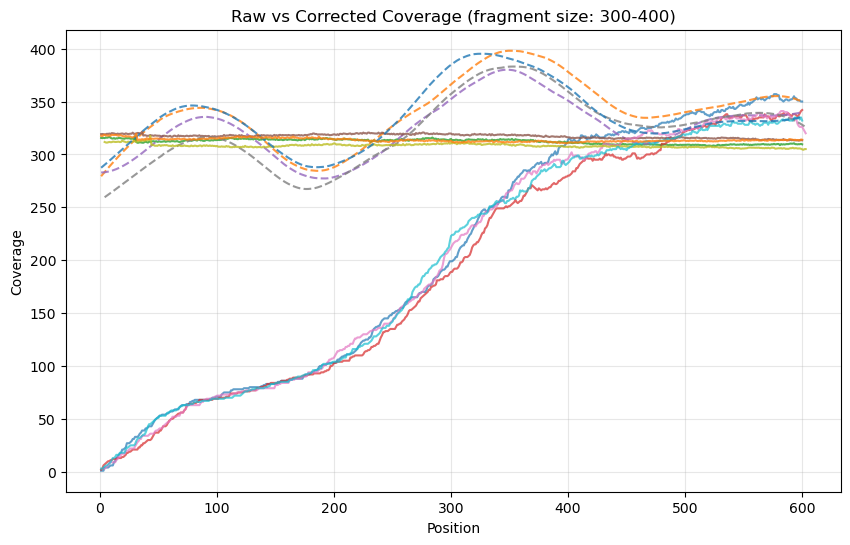

In [2]:
## Setup folder directories

edge_zone_constant = 2
y_max_scaling_factor = 0.75
expression_folder_path = "./expression/"
fragment_size_folder_path = "./fragment_size/"

fragment_sizes = [[100, 200], [200,300], [250, 450], [300, 400], [500, 600]]

# Initialize list to collect plot_data DataFrames for all genes
all_plot_data = []
plt.figure(figsize=(10,6))

## plot 4 genes for the fragment size 300 - 400 bin to create a plot
for frag_min, frag_max in fragment_sizes[3:4]:

    fragment_size_ground_truth_path = f"{fragment_size_folder_path}/fragments_{frag_min}-{frag_max}/all_pre_selection"
    fragment_size_data_path = f"{fragment_size_folder_path}/fragments_{frag_min}-{frag_max}/all_after_selection"
    data_tsv = glob.glob(os.path.join(fragment_size_data_path, "*.tsv"))

    for tsv_file in data_tsv[0:4]:

        gene_name = os.path.splitext(os.path.basename(tsv_file))[0]
        data_after_size_select = pd.read_csv(tsv_file, sep='\t')
        data_pre_size_select = pd.read_csv(f"{fragment_size_ground_truth_path}/{gene_name}.tsv", sep='\t')

        L = len(data_after_size_select['position'])
        y_max = data_after_size_select['frequency'].max()

        ## we are setting x_end to be edge_zone_constant * frag_min. 
        ## but need to make sure this is not greater than the length of the gene
        ## and that the x_end position is consistent with the ground truth
        ## so we take the minimum of the three
        ## in the actual data that we consider all genes have length greater than edge_zone_constant * frag_min 
        ## so this is not an issue in practice
        x_end = min(min(edge_zone_constant * frag_min, L), len(data_pre_size_select['position']))
        
        ## weibull parameters   
        delta = np.log10(L)
        ## for the edge effect correction, natural to use the min fragment size as the eta parameter
        ## because we are most chiefly concerned with the edge effect caused by dropping the smallest fragments 
        ## rather than the largest fragments 
        eta = frag_min 
        n = L / (eta * gamma(1 + 1/delta))
 
        x_obs = data_after_size_select['position'][0:x_end]
        y_obs = data_after_size_select['frequency'][0:x_end] 
        y_obs_smoothed = savgol_filter(y_obs, window_length=100, polyorder=3)

        correction_factor = np.zeros(x_obs.shape)

        for i, x in enumerate(x_obs):
            correction_factor[i] = correction_second_order(x, frag_min, frag_max, delta, eta)
 
        correction_factor_scaled = correction_factor * y_max * y_max_scaling_factor

        raw_y = y_obs
        linear_y = get_linear_correction(data_after_size_select, x_end)[0:x_end]
        corrected_y = y_obs_smoothed  +  correction_factor_scaled
        truth_y = data_pre_size_select['frequency'][0:x_end]

        plt.plot(x_obs, 
                raw_y, 
                label=f'Raw expression for {gene_name}', alpha=0.7)
        plt.plot(x_obs, corrected_y, '--', 
            label=f' Corrected expression for {gene_name}', alpha=0.8)
        plt.plot(x_obs, truth_y, '-', label=f'Truth (pre-size select) for {gene_name}', alpha=0.8)

        plot_data = pd.DataFrame({
            'x_obs': x_obs,
            'raw_y': raw_y,
            'corrected_y': corrected_y,
            'truth_y': truth_y
        })
        plot_data['gene_name'] = gene_name
        all_plot_data.append(plot_data)


plt.xlabel('Position')
plt.ylabel('Coverage')
plt.title(f'Raw vs Corrected Coverage (fragment size: {frag_min}-{frag_max})')
plt.grid(True, alpha=0.3)
# plt.legend()
plt.savefig(f"./figures/panel_2b_fragment_size_{frag_min}-{frag_max}.png", 
            dpi=300, 
            bbox_inches='tight')
plt.show()

# Concatenate all gene data and save as one big CSV for this fragment size
all_data_df = pd.concat(all_plot_data, ignore_index=True)
all_data_df.to_csv(
    f"./csv_output/panel_2b_fragment_size_{frag_min}-{frag_max}.csv",
    index=False
)


In [3]:

# Create a multidimensional array to store MAE for raw, linear, and corrected relative to truth
# for each fragment size and each gene

num_fragment_sizes = len(fragment_sizes)
num_genes_per_frag = 48
mape_all = np.zeros((num_fragment_sizes, num_genes_per_frag, 3))

for frag_idx, (frag_min, frag_max) in enumerate(fragment_sizes):

    fragment_size_ground_truth_path = f"{fragment_size_folder_path}/fragments_{frag_min}-{frag_max}/all_pre_selection"
    fragment_size_data_path = f"{fragment_size_folder_path}/fragments_{frag_min}-{frag_max}/all_after_selection"
    data_tsv = glob.glob(os.path.join(fragment_size_data_path, "*.tsv"))

    for gene_idx, tsv_file in enumerate(data_tsv):

        print(f"Processing gene {gene_idx+1} of {len(data_tsv)}")
        ## setup below the same as in the previous cell
        gene_name = os.path.splitext(os.path.basename(tsv_file))[0]

        data_after_size_select = pd.read_csv(tsv_file, sep='\t')
        data_pre_size_select = pd.read_csv(f"{fragment_size_ground_truth_path}/{gene_name}.tsv", sep='\t')

        L = len(data_after_size_select['position'])
        y_max = data_after_size_select['frequency'].max()

        x_end = min(min(edge_zone_constant * frag_min, L), len(data_pre_size_select['position']))
        delta = np.log10(L)
        eta = frag_min 
        n = L / (eta * gamma(1 + 1/delta))
 
        x_obs = data_after_size_select['position'][0:x_end]
        y_obs = data_after_size_select['frequency'][0:x_end] 
        y_obs_smoothed = savgol_filter(y_obs, window_length=100, polyorder=3)

        correction_factor = np.zeros(x_obs.shape)

        for i, x in enumerate(x_obs):
            correction_factor[i] = correction_second_order(x, frag_min, frag_max, delta, eta)
 
        correction_factor_scaled = correction_factor * y_max * y_max_scaling_factor

        # Comparisons
        raw_y = y_obs
        linear_y = get_linear_correction(data_after_size_select, x_end)[0:x_end]
        corrected_y = y_obs_smoothed +  correction_factor_scaled
        truth_y = data_pre_size_select['frequency'][0:x_end]
        
        # compute mae of raw, corrected, and linear vs truth
        mape_raw = get_mape(raw_y, truth_y)
        mape_corrected = get_mape(corrected_y, truth_y)
        mape_linear =  get_mape(linear_y, truth_y)
        mape_all[frag_idx, gene_idx, :] = [mape_raw, mape_linear, mape_corrected]

fragment_labels = [f"{frag_min}-{frag_max}" for frag_min, frag_max in fragment_sizes]
num_genes = mape_all.shape[1]

# Construct MultiIndex for rows
arrays = [
    np.repeat(fragment_labels, num_genes),
    np.tile([f"Gene_{i+1}" for i in range(num_genes)], len(fragment_labels))
]
index = pd.MultiIndex.from_arrays(arrays, names=["FragmentSize", "Gene"])

# Flatten data to 2D for DataFrame: (num_fragment_sizes * num_genes, num_methods)
mape_flat = mape_all.reshape(-1, mape_all.shape[2])

methods = ['Raw Data', 'Linear Correction', 'Probabilistic Correction']
df_mape = pd.DataFrame(mape_flat, index=index, columns=methods)
df_mape.to_csv("./csv_output/mape_per_fragment.csv")
print("Saved mape_all csv")



Processing gene 1 of 48
Processing gene 2 of 48
Processing gene 3 of 48
Processing gene 4 of 48
Processing gene 5 of 48
Processing gene 6 of 48
Processing gene 7 of 48
Processing gene 8 of 48
Processing gene 9 of 48
Processing gene 10 of 48
Processing gene 11 of 48
Processing gene 12 of 48
Processing gene 13 of 48
Processing gene 14 of 48
Processing gene 15 of 48
Processing gene 16 of 48
Processing gene 17 of 48
Processing gene 18 of 48
Processing gene 19 of 48
Processing gene 20 of 48
Processing gene 21 of 48
Processing gene 22 of 48
Processing gene 23 of 48
Processing gene 24 of 48
Processing gene 25 of 48
Processing gene 26 of 48
Processing gene 27 of 48
Processing gene 28 of 48
Processing gene 29 of 48
Processing gene 30 of 48
Processing gene 31 of 48
Processing gene 32 of 48
Processing gene 33 of 48
Processing gene 34 of 48
Processing gene 35 of 48
Processing gene 36 of 48
Processing gene 37 of 48
Processing gene 38 of 48
Processing gene 39 of 48
Processing gene 40 of 48
Processin


Paired t-test (Raw vs Corrected) for each fragment size:
Fragment size 100-200: t=22.5, p-value=7.73e-27
Fragment size 200-300: t=21.5, p-value=5.49e-26
Fragment size 250-450: t=15.8, p-value=2.2e-20
Fragment size 300-400: t=14.5, p-value=5.22e-19
Fragment size 500-600: t=8.03, p-value=2.31e-10

Paired t-test (Linear vs Corrected) for each fragment size:
Fragment size 100-200: t=13.1, p-value=2.32e-17
Fragment size 200-300: t=10.4, p-value=7.8e-14
Fragment size 250-450: t=8.75, p-value=1.97e-11
Fragment size 300-400: t=6.67, p-value=2.6e-08
Fragment size 500-600: t=2.9, p-value=0.00564
Saved paired t-test results to paired_ttest_fragmentsizes.csv


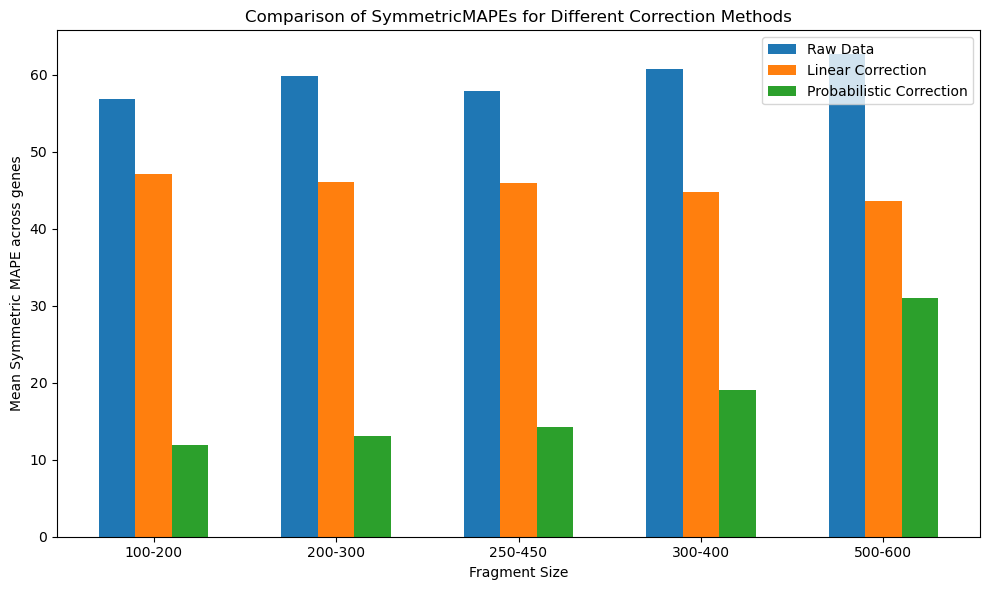

In [ ]:
# Collect t-test results in lists for CSV output
frag_labels = [f"{frag_min}-{frag_max}" for frag_min, frag_max in fragment_sizes]
raw_vs_corr_t = []
raw_vs_corr_p = []
linear_vs_corr_t = []
linear_vs_corr_p = []

print("\nPaired t-test (Raw vs Corrected) for each fragment size:")
for idx in range(len(fragment_sizes)):
    t_stat, p_val = ttest_rel(mape_all[idx, :, 0], mape_all[idx, :, 2])
    frag_min, frag_max = fragment_sizes[idx]
    print(f"Fragment size {frag_min}-{frag_max}: t={t_stat:.3g}, p-value={p_val:.3g}")
    raw_vs_corr_t.append(t_stat)
    raw_vs_corr_p.append(p_val)

print("\nPaired t-test (Linear vs Corrected) for each fragment size:")
for idx in range(len(fragment_sizes)):
    t_stat, p_val = ttest_rel(mape_all[idx, :, 1], mape_all[idx, :, 2])
    frag_min, frag_max = fragment_sizes[idx]
    print(f"Fragment size {frag_min}-{frag_max}: t={t_stat:.3g}, p-value={p_val:.3g}")
    linear_vs_corr_t.append(t_stat)
    linear_vs_corr_p.append(p_val)


ttest_df = pd.DataFrame({
    "FragmentSize": frag_labels,
    "Tstat Raw vs Corrected": raw_vs_corr_t,
    "Pval Raw vs Corrected": raw_vs_corr_p,
    "Tstat Linear vs Corrected": linear_vs_corr_t,
    "Pval Linear vs Corrected": linear_vs_corr_p
})
ttest_df.to_csv("./csv_output/paired_ttest_fragmentsizes.csv", index=False)
print("Saved paired t-test results to paired_ttest_fragmentsizes.csv")

# Compute mean mae across genes for each fragment size and correction type
mean_mape = np.mean(mape_all, axis=1)  # shape: (num_fragment_sizes, 3)
std_mae = np.std(mape_all, axis=1)    # shape: (num_fragment_sizes, 3)  

num_fragment_sizes = mean_mape.shape[0]
x = np.arange(num_fragment_sizes)  # bar locations

bar_width = 0.2

plt.figure(figsize=(10, 6))

for i in range(3):
    plt.bar(x + (i-1)*bar_width, mean_mape[:,i], width=bar_width, label=methods[i], align='center')

plt.xlabel('Fragment Size')
plt.ylabel('Mean Symmetric MAPE across genes')
plt.title('Comparison of Symmetric MAPEs for Different Correction Methods')
plt.xticks(x, [f'{frag_min}-{frag_max}' for frag_min, frag_max in fragment_sizes])
plt.legend()
plt.tight_layout()
plt.savefig("./figures/panel_2c_comparison_frag_size_barplot.png", dpi=300, bbox_inches='tight')
plt.show()


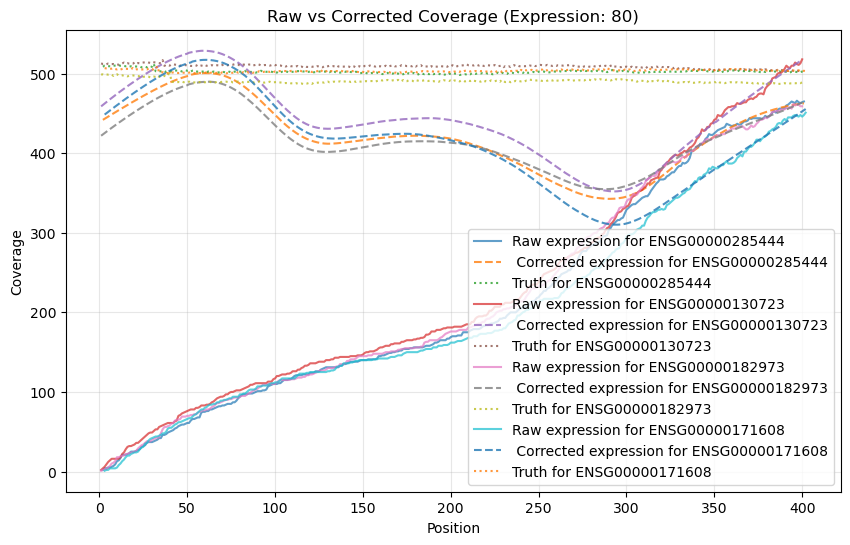

In [5]:
## Now move on to expression level differences


expression_levels = [5, 10, 20, 40, 80, 160] 

plt.figure(figsize=(10,6))

## pick an expression level bin to plot 
for expression_level in expression_levels[4:5]:

    expression_ground_truth_path = f"{expression_folder_path}/TPM_{expression_level}/all_pre_selection"
    expression_data_path = f"{expression_folder_path}/TPM_{expression_level}/all_after_selection"
    data_tsv = glob.glob(os.path.join(expression_data_path, "*.tsv"))

    for tsv_file in data_tsv[0:4]:
        frag_min = 200
        frag_max = 300

        gene_name = os.path.splitext(os.path.basename(tsv_file))[0]

        data_after_size_select = pd.read_csv(tsv_file, sep='\t')
        data_pre_size_select = pd.read_csv(f"{expression_ground_truth_path}/{gene_name}.tsv", sep='\t')

        L = len(data_after_size_select['position'])
        y_max = data_after_size_select['frequency'].max()
        delta = np.log10(L)
        eta = frag_min
        n = L / (eta * gamma(1 + 1/delta))

        x_end = min(min(edge_zone_constant * frag_min, L), len(data_pre_size_select['position']))

        x_obs = data_after_size_select['position'][0:x_end]
        y_obs = data_after_size_select['frequency'][0:x_end] 
        y_obs_smoothed = savgol_filter(y_obs, window_length=100, polyorder=3)

        correction_factor = np.zeros(x_obs.shape)
        for i, x in enumerate(x_obs):
            correction_factor[i] = correction_second_order(x, frag_min, frag_max, delta, eta)
 
        correction_factor_scaled = correction_factor * y_max * y_max_scaling_factor

        raw_y = y_obs
        linear_y = get_linear_correction(data_after_size_select, x_end)[0:x_end]
        corrected_y = y_obs_smoothed +  correction_factor_scaled
        truth_y = data_pre_size_select['frequency'][0:x_end]


        plt.plot(x_obs, 
                raw_y, 
                label=f'Raw expression for {gene_name}', alpha=0.7)
        plt.plot(x_obs, corrected_y, '--', 
            label=f' Corrected expression for {gene_name}', alpha=0.8)
        plt.plot(x_obs, truth_y, ':', 
                 label=f'Truth for {gene_name}', alpha=0.8)



plt.xlabel('Position')
plt.ylabel('Coverage')
plt.title(f'Raw vs Corrected Coverage (Expression: {expression_level})')
plt.grid(True, alpha=0.3)
plt.legend()
plt.savefig(f"./figures/panel_supplement_expression_level_{expression_level}.png", 
            dpi=300, 
            bbox_inches='tight')
plt.show()



In [6]:

# Create a multidimensional array to store MAE for raw, linear, and corrected relative to truth
# for each fragment size and each gene

num_expression_levels = len(expression_levels)
num_genes_per_expression_level = 48
mape_all = np.zeros((num_expression_levels, num_genes_per_expression_level, 3))

frag_min = 200
frag_max = 300

for expression_idx, expression_level in enumerate(expression_levels):

    expression_ground_truth_path = f"{expression_folder_path}/TPM_{expression_level}/all_pre_selection"
    expression_data_path = f"{expression_folder_path}/TPM_{expression_level}/all_after_selection"
    data_tsv = glob.glob(os.path.join(expression_data_path, "*.tsv"))

    for gene_idx, tsv_file in enumerate(data_tsv):

        print(f"Processing gene {gene_idx+1} of {len(data_tsv)}")
        ## setup below the same as in the previous cell
        gene_name = os.path.splitext(os.path.basename(tsv_file))[0]

        data_after_size_select = pd.read_csv(tsv_file, sep='\t')
        data_pre_size_select = pd.read_csv(f"{expression_ground_truth_path}/{gene_name}.tsv", sep='\t')

        L = len(data_after_size_select['position'])
        y_max = data_after_size_select['frequency'].max()

        x_end = min(min(edge_zone_constant * frag_min, L), len(data_pre_size_select['position']))
        delta = np.log10(L)
        eta = frag_min 
        n = L / (eta * gamma(1 + 1/delta))
 
        x_obs = data_after_size_select['position'][0:x_end]
        y_obs = data_after_size_select['frequency'][0:x_end] 
        y_obs_smoothed = savgol_filter(y_obs, window_length=100, polyorder=3)

        correction_factor = np.zeros(x_obs.shape)

        for i, x in enumerate(x_obs):
            correction_factor[i] = correction_second_order(x, frag_min, frag_max, delta, eta)
 
        correction_factor_scaled = correction_factor * y_max * y_max_scaling_factor

        # Comparisons
        raw_y = y_obs
        linear_y = get_linear_correction(data_after_size_select, x_end)[0:x_end]
        corrected_y = y_obs_smoothed +  correction_factor_scaled
        truth_y = data_pre_size_select['frequency'][0:x_end]
        
        # compute mae of raw, corrected, and linear vs truth
        mape_raw = get_mape(raw_y, truth_y)
        mape_corrected = get_mape(corrected_y, truth_y)
        mape_linear =  get_mape(linear_y, truth_y)
        mape_all[expression_idx, gene_idx, :] = [mape_raw, mape_linear, mape_corrected]

expression_labels = [str(expr) for expr in expression_levels]
num_genes = mape_all.shape[1]

# Construct MultiIndex for rows
arrays = [
    np.repeat(expression_labels, num_genes),
    np.tile([f"Gene_{i+1}" for i in range(num_genes)], len(expression_labels))
]
index = pd.MultiIndex.from_arrays(arrays, names=["ExpressionLevel", "Gene"])

# Flatten data to 2D for DataFrame: (num_expression_levels * num_genes, num_methods)
mape_flat = mape_all.reshape(-1, mape_all.shape[2])

df_mape = pd.DataFrame(mape_flat, index=index, columns=methods)
df_mape.to_csv("./csv_output/mape_per_expression.csv")
print("Saved mape_per_expression csv")

Processing gene 1 of 48
Processing gene 2 of 48
Processing gene 3 of 48
Processing gene 4 of 48
Processing gene 5 of 48
Processing gene 6 of 48
Processing gene 7 of 48
Processing gene 8 of 48
Processing gene 9 of 48
Processing gene 10 of 48
Processing gene 11 of 48
Processing gene 12 of 48
Processing gene 13 of 48
Processing gene 14 of 48
Processing gene 15 of 48
Processing gene 16 of 48
Processing gene 17 of 48
Processing gene 18 of 48
Processing gene 19 of 48
Processing gene 20 of 48
Processing gene 21 of 48
Processing gene 22 of 48
Processing gene 23 of 48
Processing gene 24 of 48
Processing gene 25 of 48
Processing gene 26 of 48
Processing gene 27 of 48
Processing gene 28 of 48
Processing gene 29 of 48
Processing gene 30 of 48
Processing gene 31 of 48
Processing gene 32 of 48
Processing gene 33 of 48
Processing gene 34 of 48
Processing gene 35 of 48
Processing gene 36 of 48
Processing gene 37 of 48
Processing gene 38 of 48
Processing gene 39 of 48
Processing gene 40 of 48
Processin


Paired t-test (Raw vs Corrected) for each expression level:
Expression Level 5: t=17, p-value=1.12e-21
Expression Level 10: t=20.9, p-value=1.98e-25
Expression Level 20: t=24.2, p-value=3.28e-28
Expression Level 40: t=24.3, p-value=3.15e-28
Expression Level 80: t=24.7, p-value=1.34e-28
Expression Level 160: t=23.5, p-value=1.34e-27

Paired t-test (Linear vs Corrected) for each expression level:
Expression Level 5: t=11.7, p-value=1.5e-15
Expression Level 10: t=13.8, p-value=3.49e-18
Expression Level 20: t=15.4, p-value=5.65e-20
Expression Level 40: t=15.8, p-value=2.05e-20
Expression Level 80: t=15.9, p-value=1.67e-20
Expression Level 160: t=15.4, p-value=5.88e-20
Saved t-test p-values and statistics to paired_ttest_expressionlevels.csv


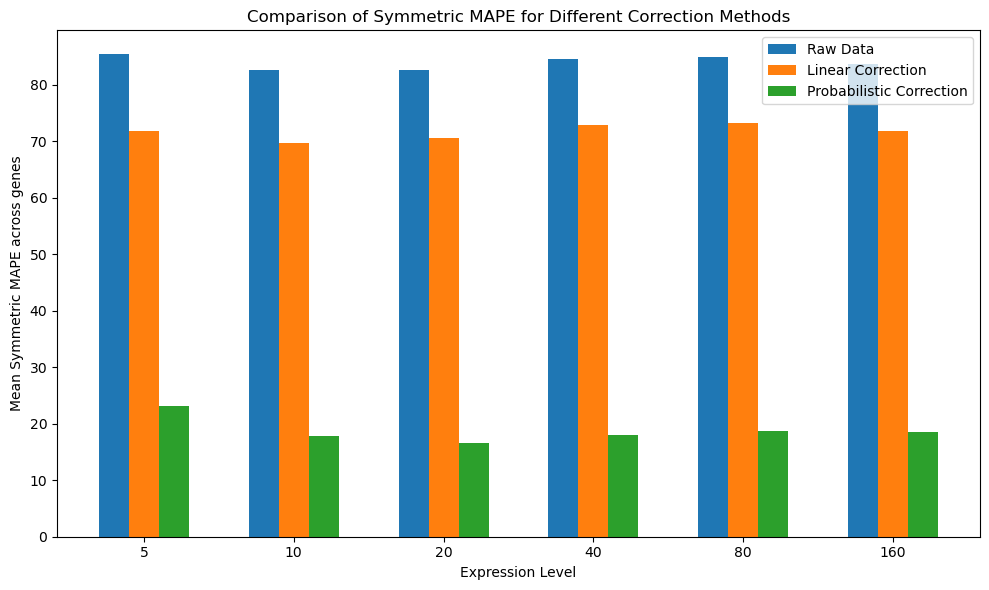

In [7]:

# Prepare lists to store t-stats and p-values for each test
raw_vs_corr_t = []
raw_vs_corr_p = []
linear_vs_corr_t = []
linear_vs_corr_p = []

print("\nPaired t-test (Raw vs Corrected) for each expression level:")
for idx in range(len(expression_levels)):
    expression_level = expression_levels[idx]
    t_stat, p_val = ttest_rel(mape_all[idx, :, 0], mape_all[idx, :, 2])
    print(f"Expression Level {expression_level}: t={t_stat:.3g}, p-value={p_val:.3g}")
    raw_vs_corr_t.append(t_stat)
    raw_vs_corr_p.append(p_val)

print("\nPaired t-test (Linear vs Corrected) for each expression level:")
for idx in range(len(expression_levels)):
    expression_level = expression_levels[idx]
    t_stat, p_val = ttest_rel(mape_all[idx, :, 1], mape_all[idx, :, 2])
    print(f"Expression Level {expression_level}: t={t_stat:.3g}, p-value={p_val:.3g}")
    linear_vs_corr_t.append(t_stat)
    linear_vs_corr_p.append(p_val)

# Save p-values and t-stats to a CSV
df_pvals = pd.DataFrame({
    'ExpressionLevel': expression_levels,
    'Tstat Raw vs Corrected': raw_vs_corr_t,
    'Pval Raw vs Corrected': raw_vs_corr_p,
    'Tstat Linear vs Corrected': linear_vs_corr_t,
    'Pval Linear vs Corrected': linear_vs_corr_p
})
df_pvals.to_csv('./csv_output/paired_ttest_expressionlevels.csv', index=False)
print("Saved t-test p-values and statistics to paired_ttest_expressionlevels.csv")

# Compute mean mae across genes for each fragment size and correction type
mean_mape = np.mean(mape_all, axis=1)  # shape: (num_fragment_sizes, 3)
std_mape = np.std(mape_all, axis=1)    # shape: (num_fragment_sizes, 3) 

num_expressions = mean_mape.shape[0]
x = np.arange(num_expressions)  # bar locations

bar_width = 0.20

plt.figure(figsize=(10, 6))

for i in range(3):
    plt.bar(x + (i-1)*bar_width, mean_mape[:,i], width=bar_width, label=methods[i], align='center')

plt.xlabel('Expression Level')
plt.ylabel('Mean Symmetric MAPE across genes')
plt.title('Comparison of Symmetric MAPE for Different Correction Methods')
plt.xticks(x, [f'{expression_level}' for expression_level in expression_levels])
plt.legend()
plt.tight_layout()
plt.savefig(f"./figures/panel_supplement_mape_comparison_expression_barplot.png", 
            dpi=300, 
            bbox_inches='tight')
plt.show()
